Este proyecto consiste de 3 partes:

#Parte A

Construccion de una herramienta propia para la construcción de scanners


Para esto primero vamos a leer el archivo de especificación de Tokens, el cual va a contener el nombre del token con su expresion regular correspondiente.

Luego para cada expresión regular utilizamos el algoritmo de Thompson y convertimos estas expresiones en NFA's, para luego convertrlas en DFA's utilizando el algoritmo de construcción de subconjuntos.

Después con estos DFA's para cada expresión podemos tokenizar comprobando el string con los autómatas generados.

In [39]:
def readInput(filePath):
  """Recibe el input del archivo de texto y retorna los pares 
  [<nombre_token>,<expresion_regular>] """
  text=open(filePath,'r');
  pairs=[
    tuple(map(lambda s: s.strip(),string.split("->"))) for string in text.readlines()
  ];
  return dict(pairs)

In [40]:
def addConcat(regEx):
  """Agrega el simbolo '~' como operador de concatenación"""
  op=['~','|']
  unary=['*','+','?']
  new = ""
  inClass=False
  for char in regEx:
      if inClass:
        if char==']':
          inClass=False
        new +=char
        continue
      if(len(new)):
          prev= new[-1]
          if (prev==')' or (prev not in op+['(',chr(92)]) or prev in unary) and (char=='(' or char not in op+unary+[')']):
              new += "~"
      if char=='[':
        inClass=True
      new +=char

  return new

def postFix(regEx):
  """Pasa la expresión regular de infix a postfix"""
  new=addConcat(regEx)
  prec={
      '*':3, '+':3, '?':3, '~':2, '|':1
      }
  op=[]
  out=""
  for char in new:
    if char in prec:
      
      while len(op) and op[-1] not in "()" and prec[op[-1]]> prec[char]:
        out+=op.pop()
      op.append(char)
    elif char=='(':
      op.append(char)
    elif char==')':
      while len(op) and op[-1]!= '(':
        out+=op.pop()
      op.pop()
    else:
      out+=char
  while len(op)>0:
    out+=op.pop()
  
  return out  

In [41]:
#Funciones auxiliares
def include(dicc,key,l):
  if dicc.get(key)!= None:
    dicc[key].extend(l)
  else:
    dicc[key]=l

In [42]:
#Clase NFA final
"""Clase node para recorrer los nodos de los autómatas"""
class node:
  trans={}
  def __init__(self,dic):
    self.trans=dic

"""Clase NFA para la construcción de autómatas NFA y luego pasarlos a DFA"""
class NFA:
  start=None;
  accepting=None;

  def __init__(self, exp, inClass=False):
    self.accepting=node({})
    if inClass:
      self.start=node({})
      i=0
      while(i<(len(exp)-2)):
        if(exp[i+1]=='-'):
          for j in range(ord(exp[i]),ord(exp[i+2])+1):
            self.start.trans[chr(j)]=[self.accepting]
          i+=2
        else:
            self.start.trans[exp[i]]=[self.accepting]
        i+=1
      while(i<len(exp)):
        self.start.trans[exp[i]]=[self.accepting]
        i+=1
    else:
      self.start=node({exp:[self.accepting]})

  def __str__(self):
    
    oldstates=[self.start]
    newstates=[{}]
    stack=[self.start]
    while(len(stack)):
      
      curr=stack.pop()
      
      for key,value in curr.trans.items():
        
        for n in value:
          if n not in oldstates:
            stack.append(n)
            oldstates.append(n)
            newstates.append({})
          include(newstates[oldstates.index(curr)],key,[oldstates.index(n)])
          

    return str(newstates)+str(oldstates.index(self.accepting))

  
#---------------Operadores de expresión regular--------------------

  def concatenation(self, other):  
    other.accepting.trans=self.start.trans  
    other.accepting=self.accepting
    
    return other

  def union(self, other):
    other.start=node({'ϵ':[other.start,self.start]})
    finalNode=node({})
    include(other.accepting.trans,'ϵ',[finalNode])
    include(self.accepting.trans,'ϵ',[finalNode])
    other.accepting=finalNode
    
    return other

  def kleene(self):
    finalNode=node({})
    include(self.accepting.trans,'ϵ',[self.start,finalNode])
    self.start=node({'ϵ':[self.start,finalNode]})
    self.accepting=finalNode

    return self
    
  def positive(self):
    finalNode=node({})
    include(self.accepting.trans,'ϵ',[self.start,finalNode])
    self.start=node({'ϵ':[self.start]})
    self.accepting=finalNode

    return self

  def optional(self):
    finalNode=node({})
    include(self.accepting.trans,'ϵ',[finalNode])
    self.start=node({'ϵ':[self.start,finalNode]})
    self.accepting=finalNode

    return self

#----------------------Construcción de subconjuntos---------------------
  
  def e_clausura(self,state):
    C=[state]
    notChecked=0
    
    while(len(C)>notChecked):
      if C[notChecked].trans.get('ϵ')!= None:
        C=C+C[notChecked].trans['ϵ']
      notChecked+=1

    return set(C)

  def e_clausura_set(self,conj):
    c=set([i for i in conj])
    stack=[i for i in conj]
    while(len(stack)):
      t=stack.pop()
      if t.trans.get('ϵ')!= None:
        for u in t.trans['ϵ']:
          if u not in c:
            c.add(u)
            stack.append(u)
    return c

  def Trans(self,state,char):
    S=set({})
    if state.trans.get(char)!= None:
      S =S|set(state.trans[char])

    return S
  
  def Trans_set(self,conj,char):
    S=set({})
    for i in conj:
      S=S|self.Trans(i,char)
    return S

  def getSymbols(self,conj):
    """Obtiene todos los símbolos con transiciones del conjunto"""
    symbols=set({})
    for i in conj:
      symbols=symbols|set(i.trans.keys())
    return symbols

  def NFA_to_DFA(self):
    """Algoritmo de construccion de subconjuntos """
    Dstates=[self.e_clausura(self.start)]

    notMarked=0
    accepting=[]
    DFA=[node({})]
    if self.accepting in Dstates[0]:
      accepting.append(0)

    while(len(Dstates)>notMarked):
      T=Dstates[notMarked]
      
      symbols=self.getSymbols(T)-{'ϵ'}
      
      for char in symbols:
        U=self.e_clausura_set(self.Trans_set(T,char));

        if U not in Dstates:
          Dstates.append(U)
          newNode=node({})

          if self.accepting in U:
            accepting.append(len(DFA))
          DFA.append(newNode)
          DFA[notMarked].trans[char]=newNode
        else:
          DFA[notMarked].trans[char]=DFA[Dstates.index(U)]
      notMarked+=1
   
    return DFA,accepting


In [43]:
def pfToNFA(postfix):
  """recibe la cadena en postfix para retornar el NFA como diccionario
  """
  stack=[]

  operations={
    '*':lambda st: st.pop().kleene(),
    '+':lambda st: st.pop().positive(),
    '?':lambda st: st.pop().optional(),
    '~':lambda st: st.pop().concatenation(st.pop()),
    '|':lambda st: st.pop().union(st.pop()),
  }
  i=0;
  while(i<len(postfix)):
    if operations.get(postfix[i])==None:
      if postfix[i]==chr(92):

        stack.append(NFA(postfix[i+1])) 
        i+=1
      elif postfix[i]=='[' :
        clas=""
        while(postfix[i+1]!=']'):
          i+=1
          clas+=postfix[i]
        i+=1
        stack.append(NFA(clas,inClass=True))  
      else:
        stack.append(NFA(postfix[i]))      
    else:
      stack.append(operations[postfix[i]](stack))
    i+=1
  return stack.pop()

In [44]:
def DFAtoMatrix(DFA,accepting):
  """Retorna la matriz del automata para ascii"""
  matrix=[[-1 for j in range(256)] for i in DFA] 
  for i in range(len(DFA)):
    for j in DFA[i].trans.keys():
      matrix[i][ord(j)]=DFA.index(DFA[i].trans[j])
  return matrix

def printDFA(DFA, ac):
  oldstates=[DFA[0]]
  newstates=[{}]
  stack=[DFA[0]]
  while(len(stack)): 
    curr=stack.pop()
    for key,value in curr.trans.items():
      if value not in oldstates:
        stack.append(value)
        oldstates.append(value)
        newstates.append({})
      include(newstates[oldstates.index(curr)],key,oldstates.index(value))
  print(newstates)
  for i in ac:
    print(i)
  

In [45]:
def TokenIz(TokList, string):
  """Tokeniza el string o texto ingresado con las especificaciones dadas por 
  TokList (diccionario de las especificaciones)
  """
  tokens=[]
  automatons={}

  for key in TokList:
    dfa,ac=pfToNFA(postFix(TokList[key])).NFA_to_DFA()    
    automatons[key]=(DFAtoMatrix(dfa,ac),ac)

  toCheck=list(automatons.keys())
  state = [0 for k in automatons]

  accepted=[]
  i=0
  start=1
  while i<len(string):
    
    j = 0 
    while j < len(toCheck):
      mat = automatons[toCheck[j]][0]
      if mat[state[j]][ord(string[i])] != -1:
        state[j] = mat[state[j]][ord(string[i])]
        j += 1
      else:
        toCheck.pop(j)
        state.pop(j)

    if not len(toCheck):
      if not len(accepted):
        print("Syntax Error")
        return
      print(
          "Tipo de token "+ accepted[0] + " - Posición inicial:"+ str(start)+
          " - Posición final:" + str(i) + " - Valor:\'" + string[start-1:i] + "\'"
          )
      tokens.append((accepted[0],start-1,i))
      start = i+1
      toCheck = list(automatons.keys())
      state = [0 for k in automatons]
      continue
      
    accepted=[]

    for k in range(len(toCheck)):   
      if state[k] in automatons[toCheck[k]][1]:
        accepted.append(toCheck[k])
    i+=1
  

  if not len(accepted):
    print("Syntax Error")
    return
  print(
      "Tipo de token "+ accepted[0] + " - Posición inicial:"+ str(start)+
      " - Posición final:" + str(len(string)) + " - Valor:\'" + string[start-1:] + "\'"
      )
  tokens.append((accepted[0],start-1,i))
  return tokens
 

Ejemplo: leemos las especificaciones del archivo especificaciones.txt 

- for -> for|FOR
- identifier -> [_a-z][_a-z0-9]*
- digit -> [0-9][0-9]*
- space -> [ ]
- equal -> =

y utilizando esto podemos tokenizar el string 'for a = 1'. 

In [46]:
""" Leemos el texto a tokenizar """ 
example = 'for a = 1'


""" Leemos las especificaciones: """
test = readInput("especificaciones.txt")


tokens = TokenIz(test,example)

Tipo de token for - Posición inicial:1 - Posición final:3 - Valor:'for'
Tipo de token space - Posición inicial:4 - Posición final:4 - Valor:' '
Tipo de token identifier - Posición inicial:5 - Posición final:5 - Valor:'a'
Tipo de token space - Posición inicial:6 - Posición final:6 - Valor:' '
Tipo de token equal - Posición inicial:7 - Posición final:7 - Valor:'='
Tipo de token space - Posición inicial:8 - Posición final:8 - Valor:' '
Tipo de token digit - Posición inicial:9 - Posición final:9 - Valor:'1'


#Puntos adicionales

1. Por dibujar automáticamente los autómatas finitos determinísticos utilizados
para el reconocimiento de los tokens individuales.

In [47]:
#Graficas para símbolos individuales

import graphviz  # doctest: +NO_EXE
import matplotlib.pyplot as plt 

#Lee un DFA y lo dibuja:
#NOTA: DFA ESTA EN MATRIZ
#ACCEPT es lista de estados de aceptacion
#ALPHA es alfabeto utilizado 
def DrawDFA(DFA, ACCEPT, ALPHA):
    automata = graphviz.Digraph(format='PNG')
    state=0
    name=0
    print("test")
    for i in DFA:  
        state_name = 'q' + str(state)
        if state in ACCEPT:
            automata.node(str(name), state_name, shape = "doublecircle")
        else:
            automata.node(str(name), state_name, shape = "circle")
        for j in range(len(i)):
            #testdict = {}
            if i[j] != -1:
                #testdict[str(i[j])] = ALPHA[j]
                automata.edge(str(name), str(i[j]) ,label = ALPHA[j])
        #print(">> testdict: ", testdict)
        state +=1
        name +=1
    return automata

In [48]:
#### "Version mejorada"
#Multiples símbolos

import graphviz  # doctest: +NO_EXE
import matplotlib.pyplot as plt 
import more_itertools as mit


#Lee un DFA y lo dibuja:
#NOTA: DFA ESTA EN MATRIZ
#ACCEPT es lista de estados de aceptacion
#ALPHA es alfabeto utilizado 
def DrawDFA2(DFA, ACCEPT, ALPHA):
    automata = graphviz.Digraph(format='PNG')
    state=0
    name=0
    for i in DFA:  
        state_name = 'q' + str(state)
        if state in ACCEPT:
            automata.node(str(name), state_name, shape = "doublecircle")
        else:
            automata.node(str(name), state_name, shape = "circle")
        testdict = {}
        for j in range(len(i)):
            if i[j] != -1:
                if i[j] not in testdict:
                  testdict[i[j]] = [ALPHA[j]]
                else:
                  testdict[i[j]] += [ALPHA[j]]
                #testdict[str(i[j])] = ALPHA[j]
                #automata.edge(str(name), str(i[j]) ,label = ALPHA[j])
        for i in testdict:   
          labellascii = [ord(j) for j in testdict[i]]
          groups = [list(labell) for labell in mit.consecutive_groups(labellascii)]
          labeltext = ""
          for j in groups:   
            if len(j) != 1:
              labeltext += "[" + chr(j[0]) + "-" + chr(j[-1]) + "]"
            else:
              labeltext += chr(j[0])
          automata.edge(str(name), str(i) ,label = labeltext)
        state +=1
        name +=1
    return automata

Veamos los autómatas para la especificación de estos tokens:

for -> for|FOR

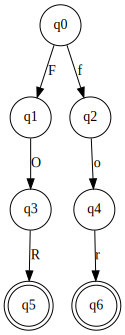

In [49]:
DFA,ac=pfToNFA(postFix('for|FOR')).NFA_to_DFA()
m=DFAtoMatrix( DFA,ac)
DrawDFA2(m, ac, [chr(i) for i in range(256)])

identifier -> [_a-z][_a-z0-9]*

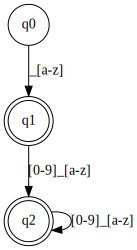

In [50]:
DFA,ac=pfToNFA(postFix('[_a-z][_a-z0-9]*')).NFA_to_DFA()
m=DFAtoMatrix( DFA,ac)
DrawDFA2(m, ac, [chr(i) for i in range(256)])

digit -> [0-9][0-9]*

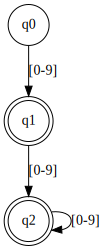

In [51]:
DFA,ac=pfToNFA(postFix('[0-9][0-9]*')).NFA_to_DFA()
m=DFAtoMatrix( DFA,ac)
DrawDFA2(m, ac, [chr(i) for i in range(256)])

space -> [ ]

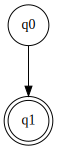

In [52]:
DFA,ac=pfToNFA(postFix('[ ]')).NFA_to_DFA()
m=DFAtoMatrix( DFA,ac)
DrawDFA2(m, ac, [chr(i) for i in range(256)])

equal -> =

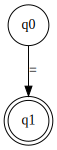

In [53]:
DFA,ac=pfToNFA(postFix('=')).NFA_to_DFA()
m=DFAtoMatrix( DFA,ac)
DrawDFA2(m, ac, [chr(i) for i in range(256)])

# Parte B

Utilizando el generador de scanners construido en el punto anterior, construya un parser de JSON.

Para este parser reporte adicionalmente:

1. La especificación informal de los tokens.
2. La especificación formal de los tokens.
3. Los grafos de los Autómatas Finitos Determinísticos utilizados para la identificación de
cada uno de los tokens.

#Especificacion informal de los tokens

Los Json tienen 6 tipos de datos, a saber:

* **STRING**: Un string se representa como una secuencia de 0 o mas caracteres Unicode, encerrados entre doble comillas (""). (Strings encerradas entre comillas simples ('') no son validas). Las string de JSON pueden contener los siguientes caracteres de control:

  - \" – Dobles comillas
  - \\ – Backslash
  - \/ – Slash al frente
  - \b – Backspace
  - \f – Salto de página
  - \n – Newline
  - \r – Salto de carro
  - \t – Tab
  - \u – Arrastrada por cuatro dígitos hexadecimales

* **NUMBER**: Este tipo de dato sigue el formato de doble punto flotante de Javascript

  - Representado en base 10 sin ceros iniciales superfluos
  - Incluye los dígitos del 0 al 9
  - Pueden ser números negativos
  - Pueden ser fracionarios (ej: .5, 0.5)
  - También puede tener un exponente de 10, precedido por e o E con un signo más o menos para indicar exponenciación positiva o negativa.
  - Formatos Octal y Hexadecimal no estan aceptados
  - No pueden tener un valor NaN o infinito

* **OBJECT**:  Un conjunto desordenado de pares de nombre/valor insertados entre llaves ({}). Un objeto puede contener cero o más pares de nombre/valor. Varios pares de nombre/valor están separados por una coma (,).

* **ARRAY**: Una colección ordenada de valores. Comienza con un corchete izquierdo ([) y termina con uno derecho (]). Sus valores están separados por una coma (,)

* **BOOLEAN**: Los valores booleanos pueden ser verdaderos o falsos. Los valores booleanos no están entre comillas y se tratarán como valores de cadena.

* **NULL**: Aunque técnicamente no es un tipo de valor, null es un valor especial en JSON. Cuando no hay ningún valor para asignar a una clave, se puede tratar como nula. el valor nulo no debe estar entre comillas



#Especificacion formal de los tokens

Siguiendo las especificaciones mencionadas anteriormente vamos a definir un token para cada tipo de dato y adicionalmente creamos:
* LeftBracket y RightBracket para reconocer el inicio y el final de un objeto
* LeftParenthesis y RightParenthsis para marcar el inicio y final de un arreglo 
* Asign que corresponde al caracter ':' que debe estar en la definición de un miembro de un objeto
* Comma para separar cada miembro de un objeto o arreglo
* Separator son los espacios en blanco o identados que se deben ignorar en el parseo

De esta manera describimos una expresión regular que pasamos como entrada a nuestro scanner en el archivo de texto Json.txt que podemos ver en la siguiente celda de codigo.

In [54]:
# Especificar tokens
!cat Json.txt

String -> "([ -!#-ÿ]|[\]")*"
Number -> ([0-9]+(.[0-9]*)?|.[0-9]+)(e-?[0-9]+)?
Boolean -> true|false
Null -> null
Separator -> ([ ]|[	])+
Asign -> :
LeftBracket -> {
RightBracket -> }
LeftParenthesis -> \[
RightParenthesis -> ]
Comma -> ,

# Los grafos de los Autómatas Finitos Determinísticos utilizados para la identificación de cada uno de los tokens.

Utilizando el graficador automático de Autómatas Finitos Determinísticos es posible generar estos grafos:


Number -> ([0-9]+(.[0-9]*)?|.[0-9]+)(e-?[0-9]+)?

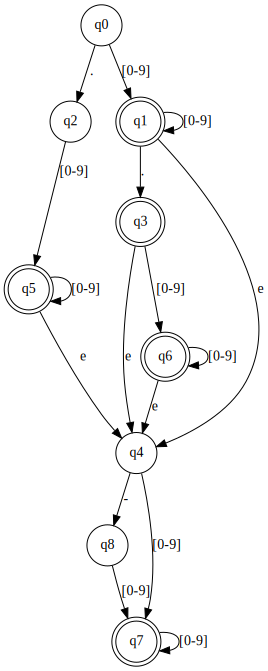

In [55]:
DFA,ac=pfToNFA(postFix('([0-9]+(.[0-9]*)?|.[0-9]+)(e-?[0-9]+)?')).NFA_to_DFA()
m=DFAtoMatrix( DFA,ac)
DrawDFA2(m, ac, [chr(i) for i in range(256)])

Boolean -> true|false

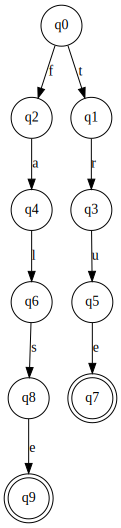

In [56]:
DFA,ac=pfToNFA(postFix('true|false')).NFA_to_DFA()
m=DFAtoMatrix( DFA,ac)
DrawDFA2(m, ac, [chr(i) for i in range(256)])

Null -> null

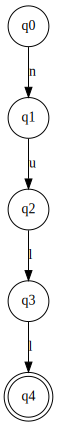

In [57]:
DFA,ac=pfToNFA(postFix('null')).NFA_to_DFA()
m=DFAtoMatrix( DFA,ac)
DrawDFA2(m, ac, [chr(i) for i in range(256)])

Separator -> ([ ]|[ \t ])+

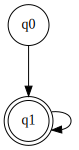

In [58]:
DFA,ac=pfToNFA(postFix('([ ]|[     ])+')).NFA_to_DFA()
m=DFAtoMatrix( DFA,ac)
DrawDFA2(m, ac, [chr(i) for i in range(256)])

Asign -> :

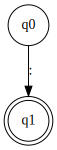

In [59]:
DFA,ac=pfToNFA(postFix(':')).NFA_to_DFA()
m=DFAtoMatrix( DFA,ac)
DrawDFA2(m, ac, [chr(i) for i in range(256)])

LeftBracket -> {


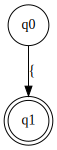

In [60]:
DFA,ac=pfToNFA(postFix('{')).NFA_to_DFA()
m=DFAtoMatrix( DFA,ac)
DrawDFA2(m, ac, [chr(i) for i in range(256)])

RightBracket -> }

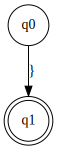

In [61]:
DFA,ac=pfToNFA(postFix('}')).NFA_to_DFA()
m=DFAtoMatrix( DFA,ac)
DrawDFA2(m, ac, [chr(i) for i in range(256)])

RightParenthesis -> ]

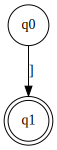

In [62]:
DFA,ac=pfToNFA(postFix(']')).NFA_to_DFA()
m=DFAtoMatrix( DFA,ac)
DrawDFA2(m, ac, [chr(i) for i in range(256)])

Comma -> ,

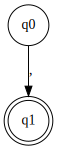

In [63]:
DFA,ac=pfToNFA(postFix(',')).NFA_to_DFA()
m=DFAtoMatrix( DFA,ac)
DrawDFA2(m, ac, [chr(i) for i in range(256)])

#Parseo Json


Para hacer el parser de Json vamos a definir "tokens" mas generales, es decir, simbolos no terminales para cada uno de estos describimos una función recursiva para cada uno, es deecir:
* DataType correspondiente a algún tipo de dato que recibe Json
* Pair correpondiente a la definición de cada miembro de un objeto
* Objec y Array que describen los tipos de datos objeto y arreglo cuya sintaxís es mas compleja


In [64]:
def parseDataType(listTokens):
  especialTypes={
    'LeftBracket': lambda lt:parseObject(lt),
    'LeftParenthesis': lambda lt:parseArray(lt),
  }
  valid={'String','Number','Boolean','Null'}
  
  if listTokens[0][0] in especialTypes:
    n=especialTypes[listTokens[0][0]](listTokens)
    if n==None:
      return None
  elif listTokens[0][0] in valid:
    n=1
  else:
    return None
  return n
 

def parsePair(listTokens):
  if listTokens[0][0]!='String' and listTokens[1][0]!='Asign':
    return None
  
  n = parseDataType(listTokens[2:])
  if n==None:
    return None
  
  return 2+n
 
  
def parseObject(listTokens):
  if listTokens[0][0]!='LeftBracket' :
    return None
  curr=1
  while True:
    n = parsePair(listTokens[curr:])
    if n==None:
      return None
    curr+=n
    if listTokens[curr][0]=='Comma':
      curr+=1
    elif listTokens[curr][0]=='RightBracket':
      curr+=1
      break
    else:
        return None
        
  return curr
    
def parseArray(listTokens):
  if listTokens[0][0]!='LeftParenthesis':
    return False
  curr=1
  while True:
    n = parseDataType(listTokens[curr:])
    if n==None:
      return None
    curr+=n
    if listTokens[curr][0]=='Comma':
      curr+=1
    elif listTokens[curr][0]=='RightParenthesis':
      curr+=1
      break
    else:
        return None
        
  return curr

def parseJson(json):
  with open(json, 'r') as file:
    string = file.read().replace('\n','')

  test = readInput("Json.txt")
  
 
  listTokens=TokenIz(test,string)
  for i in listTokens:
    if(i[0]=='Separator'):
      listTokens.remove(i)
  
  return parseObject(listTokens)==len(listTokens)

In [65]:
!cat ex.txt

{
	"departamento":8,
	"nombredepto":"Ventas",
	"director": "Juan Rodríguez",
	"empleados":[
		{
			"nombre":"Pedro",
			"apellido":"Fernández"
		},{
			"nombre":"Jacinto",
			"apellido":"Benavente"
		}
	]
}

In [66]:
if parseJson('ex.txt'):
  print("""
--------------------------------------------------
                    Json Válido
--------------------------------------------------  
  """)
else:
  print("""
--------------------------------------------------
                    Json no Válido
--------------------------------------------------  
  """)

Tipo de token LeftBracket - Posición inicial:1 - Posición final:1 - Valor:'{'
Tipo de token Separator - Posición inicial:2 - Posición final:2 - Valor:'	'
Tipo de token String - Posición inicial:3 - Posición final:16 - Valor:'"departamento"'
Tipo de token Asign - Posición inicial:17 - Posición final:17 - Valor:':'
Tipo de token Number - Posición inicial:18 - Posición final:18 - Valor:'8'
Tipo de token Comma - Posición inicial:19 - Posición final:19 - Valor:','
Tipo de token Separator - Posición inicial:20 - Posición final:20 - Valor:'	'
Tipo de token String - Posición inicial:21 - Posición final:33 - Valor:'"nombredepto"'
Tipo de token Asign - Posición inicial:34 - Posición final:34 - Valor:':'
Tipo de token String - Posición inicial:35 - Posición final:42 - Valor:'"Ventas"'
Tipo de token Comma - Posición inicial:43 - Posición final:43 - Valor:','
Tipo de token Separator - Posición inicial:44 - Posición final:44 - Valor:'	'
Tipo de token String - Posición inicial:45 - Posición final:54 

#3. Lenguaje natural

Respecto a la tarea de tokenización en procesamiento de lenguaje natural:

1. Explique brevemente en que consiste la tokenización por subpalabras (subwords).

La idea detrás de la tokenización por subpalabras es identificar qué palabras en un texto son indescomponibles y cuáles están compuestas de otras subpalabras cuyo significado es más simple que el de la palabra original. Por ejemplo en inglés la palabra *homework*, que significa tarea, puede dividirse en *home*, casa y *work*, trabajo. Esto resulta ser espacialmente importante cuando se trabaja con idiomas que permiten crear nuevas palabras arbitrariamente largas concatenando palabras existentes, como el alemán y el turco.

2. Explique brevemente en que consiste el Byte-Pair-Encoding.

El algoritmo Byte-Pair-Encoding(BPE) consiste en considerar las letras de un idioma como bytes, y buscar, en un texto determinado, cuáles son los pares de letras que se repiten con más frecuencia, para poder formar tokens con dichos pares de letras. Esto permite usar relativamente pocos tokens para tokenizar todo el texto.

3. Explique brevemente en que consiste el algoritmo unigram.

El algoritmo unigram se basa en la probabilidad que tiene cada palabra de un cierto alfabeto de aparecer en un texto determinado. Usando esto, podemos calcular la probabilidad de que cierta frase aparezca en un texto(simplemente multiplicando la probabilidad de aparación de cada palabra de la frase) o también podemos tratar de predecir cuál es la palabra que le sigue a una frase, calculando para cierto número de palabras la probabilidad condicional de que estas acompañen la frase y viendo para cuál palabra dicha probabilidad es mayor. 

4. Explique la diferencia entre estas estrategias y los parsers basados en lenguaje natural.

Las estrategias anteriormente descritas se basan única y exclusivamente en análisis estadísticos de los patrones que aparecen en el lenguaje natural. La desventaja que tienen es que no se basan directamente en las reglas gramaticales que existen en todos los idiomas hablados. Un parser basado en lenguaje natural(NLP) utiliza dichas reglas para dividir las oraciones en tokens(sustantivos, verbos, adjetivos, adverbios,...) e identificar si son gramaticalmente y semánticamente correctas, y en ese caso, darles una interpretación sensata.

Una desventaja de este enfoque es que debido a que los lenguajes evolucionaron para permitir la comunicación humana, no están estructurados de una manera que se fácil de tokenizar para los computadores, pues en muchas ocasiones una frase se puede interpretar de múltiples formas. Además de que casi todos los idiomas humanos usan metáforas, frases hechas, sarcasmo, etc. Esto hace que sea conveniente usar una red neuronal entrenada para tener en cuenta estas sutilezas y analizar correctamente los lenguajes naturales.



---

**Navegacion entre los Notebooks:**

Regresar a [Introduccion del proyecto 1](Introduccion_Proyecto1.ipynb)<br>

---

**Autores:** Alejandro Martin Salcedo, Daniel Santiago Pardo Gomez, Santiago Jimenez Salazar

---